# Import, export, fit and display light curves 

<a href="mailto:martin.millon@epfl.ch">Martin Millon</a>, 05.2020

This notebook explains how you can import light curves from a text file, and display them with PyCS3


In [1]:
import pycs3.gen.lc_func
import pycs3.gen.mrg
import pycs3.spl.topopt
import pycs3.regdiff.rslc
import pycs3.gen.util

### Importing curves

Curves can be imported from a text file. This file should contain at least 3 columns: one for the date of the observation, one for the observed magnitudes and one for their uncertainties. 

In [2]:
rdbfile = "data/trialcurves.txt"

lcs = [
    pycs3.gen.lc_func.rdbimport(rdbfile, 'A', 'mag_A', 'magerr_A', "Trial"),
    pycs3.gen.lc_func.rdbimport(rdbfile, 'B', 'mag_B', 'magerr_B', "Trial"),
    pycs3.gen.lc_func.rdbimport(rdbfile, 'C', 'mag_C', 'magerr_C', "Trial"),
    pycs3.gen.lc_func.rdbimport(rdbfile, 'D', 'mag_D', 'magerr_D', "Trial")
]



Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/A] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/B] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/C] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/D] with 192 points imported (0 of them masked).


### Displaying the light curves

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
	[Trial/A]
192 points (total), 0 of which are masked
4 seasons (gap: >60), gap length : 164.0 +/- 33.8 days
Sampling : median 4.0, mean 4.4, max 25.1, min 0.83 days
Shifts : (0.00000,0.00000,0.00) [days, mag, flux]
Colour : red
Common properties : 
   All properties : 
Comments :
   Imported from trialcurves.txt, columns (1, 2, 3)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


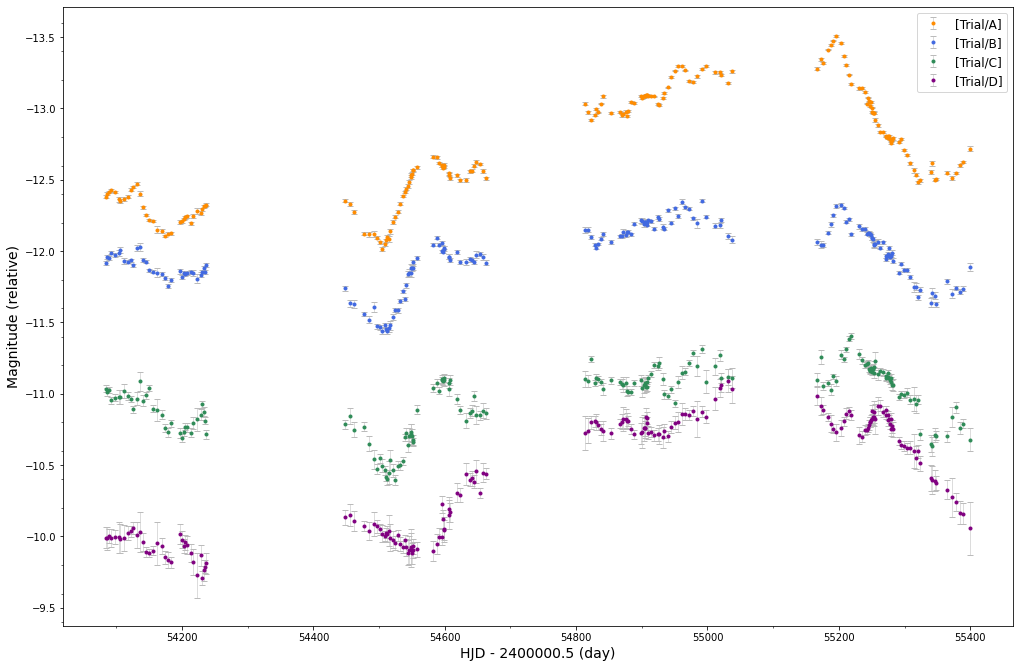

In [3]:
%matplotlib inline
print(lcs[0].longinfo())
pycs3.gen.mrg.colourise(lcs) # Gives each curve a different colour.
pycs3.gen.lc_func.display(lcs, figsize= (15,10)) 

### Time shift

We can shift the light curves manually and provide the correct time delay. 

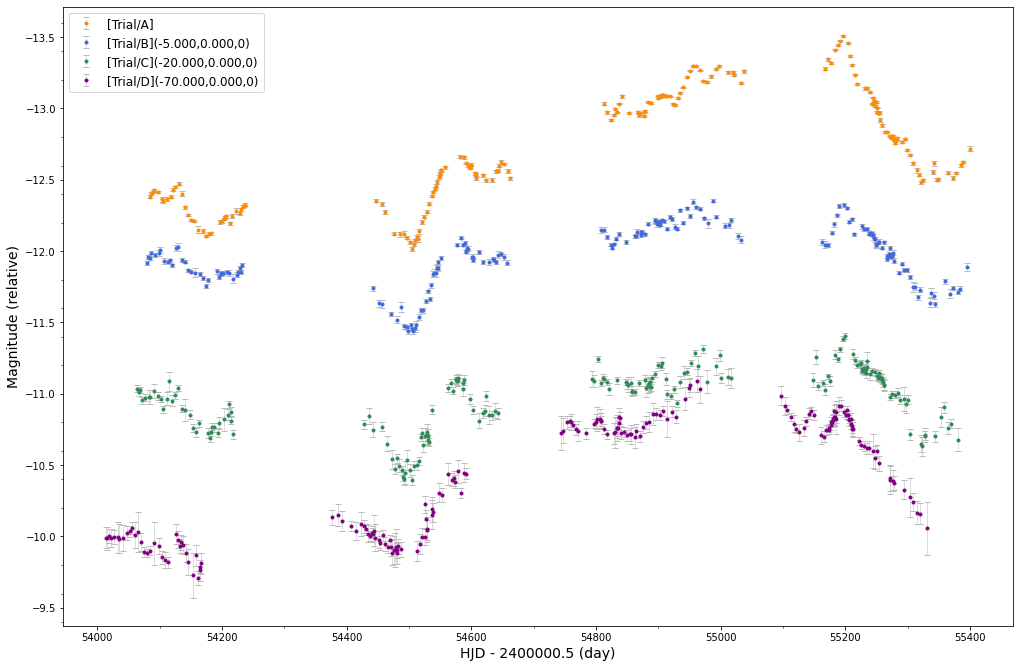

In [4]:
lcs[1].shifttime(-5.0)
lcs[2].shifttime(-20.0)
lcs[3].shifttime(-70.0)

pycs3.gen.lc_func.display(lcs, figsize= (15,10)) 

### Fitting the light curves with splines

The next example shows how you can fit a spline to your light curves. You can control the number of knots and therefore the number of degree of freedom of the fit with the `kn` parameters. It corresponds to the mean spacing between the knots. Those are equally distributed before the optimisation and are then free to move to allow more flexiblity where it is needed. 

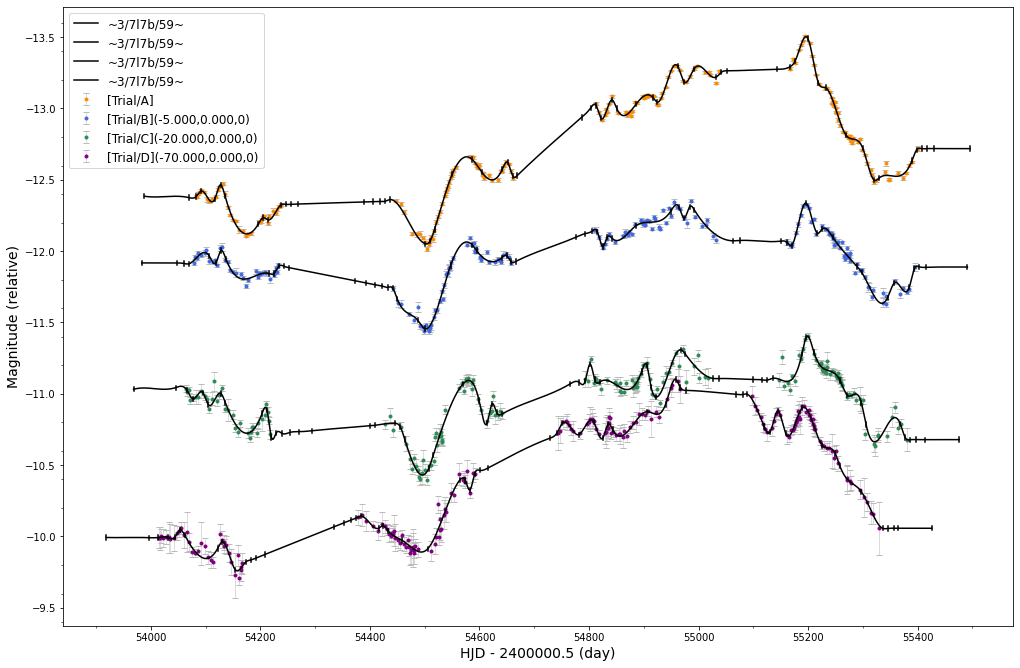

In [5]:
#Now fit a spline to the ligth curves, wihtout optimising their time shift
kn = 25 #mean spacing between the knots
splines = [] 
for lc in lcs : 
    splines.append(pycs3.spl.topopt.opt_fine([lc], knotstep=kn, bokeps=kn / 3.0, nit=5, stabext=100, shifttime=False, verbose = False))
    
pycs3.gen.lc_func.display(lcs, splines, figsize= (15,10)) 

### Fitting the light curves with regdiff

PyCS3 also offers the possibility to fit the data with Gaussian Processes. The most important parameter to choose is the kernel function. PyCS3 supports `matern`, `RBF`, `RatQuad` and is based on the `scikit-learn` implementation (see, scikit-learn [documentation](https://scikit-learn.org/stable/modules/gaussian_process.html) for details). A `matern` covariance kernel with $\nu =1.5$, works well in general. The `scale` and `amp` parameter are just starting points and are optimised so their initial values do not impact the fit in most of the cases. The `errscale` parameter is used to introduce an additionnal scaling factor of the photometric error bars. 

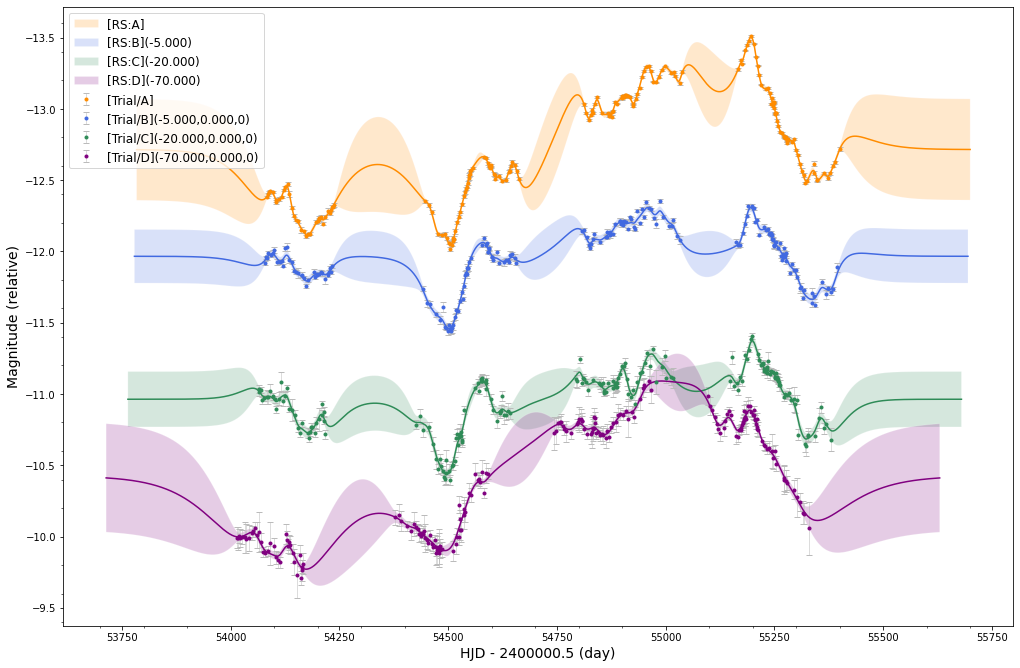

In [6]:
#Regdiff 
regdiff_param = {'pd': 2, 'covkernel': 'matern', 'pow': 1.5, 'amp': 1., 'scale': 200., 'errscale': 1.}

myrslcs = [pycs3.regdiff.rslc.factory(l, pd=regdiff_param['pd'], covkernel=regdiff_param['covkernel'],
                                    pow=regdiff_param['pow'], errscale=regdiff_param['errscale']) for l in lcs]


pycs3.gen.lc_func.display(lcs, myrslcs, figsize= (15,10) )

### Exporting

PyCS3 LightCurves object can be saved in pickle files in order to save any optimised time shift, magnitude shift, or microlensing attributes. 

In [7]:
#Export : 

# We undo these shifts, as from now on we "forget" about the true delays.
for l in lcs:
    l.resetshifts()
    
pycs3.gen.util.writepickle(lcs, "data/trialcurves.pkl")
pycs3.gen.util.multilcsexport(lcs, "data/out_trialcurves.txt", separator="\t", verbose=True, properties=None)

Wrote data/trialcurves.pkl
[Trial/A]
[Trial/B]
[Trial/C]
[Trial/D]
Wrote the lightcurves into data/out_trialcurves.txt
